In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.io import read_image
from torchvision import transforms
from torchvision import models

from tqdm import tqdm

import os

import pandas as pd

from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration
        
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'filename'] + '.png')
        image = read_image(img_path)[:3,:,:]
        filename = self.img_labels.loc[idx, 'filename']
        label = -1 if not 'sign' in self.img_labels else self.img_labels.loc[idx, 'sign']
        
        if self.transform:
            image = self.transform(image)

        return image, filename, label
    
    def getData(self):
        return list(self)

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [5]:
train_data = CustomImageDataset('../data/train.csv', '../data/avia-train/avia-train/', transform=transform)

train_data_, val_data_ = torch.utils.data.random_split(train_data, [int(len(train_data) * 0.7), int(len(train_data) * 0.3)])

test_data = CustomImageDataset('../data/test.csv', '../data/avia-test/avia-test/', transform=transform)

In [6]:
print('train_dataset len', len(train_data))

print('train_data_ len', len(train_data_))
print('val_data_ len', len(val_data_))

print('test_dataset len', len(test_data))

train_dataset len 31080
train_data_ len 21756
val_data_ len 9324
test_dataset len 1000


In [7]:
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.require = False
    
model.fc = nn.Linear(model.fc.in_features, 2)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [13]:
epochs = 20

log = {
    'train': [],
    'val': []
}


def f():
    train = DataLoader(train_data_, batch_size=200, shuffle=True)
    val = DataLoader(val_data_, batch_size=len(val_data_), shuffle=True)
    
    model.to(device)

    for epoch in range(epochs):
        running_loss_t = 0.0
        for i, data in tqdm(enumerate(train)):
            inputs, labels = data[0].to(device), data[-1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_t += loss.item()
            
        log['train'].append(running_loss_t/len(train))
        
        with torch.no_grad():
            model.eval()
            running_loss_v = 0.0
            
            for data in val:
                inputs, labels = data[0].to(device), data[-1].to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                running_loss_v += loss.item()

            log['val'].append(running_loss_v/len(val))
        
        print("Epoch {} - Training loss: {} || Val loss: {}".format(epoch, running_loss_t/len(train), running_loss_v/len(val)))
    
f()

109it [01:01,  1.78it/s]
0it [00:00, ?it/s]

Epoch 0 - Training loss: 0.032499753182258354 || Val loss: 0.05872384458780289


109it [01:00,  1.82it/s]
0it [00:00, ?it/s]

Epoch 1 - Training loss: 0.02591093677659989 || Val loss: 0.056159209460020065


109it [01:01,  1.78it/s]
0it [00:00, ?it/s]

Epoch 2 - Training loss: 0.019063443592706814 || Val loss: 0.050570208579301834


109it [00:59,  1.84it/s]
0it [00:00, ?it/s]

Epoch 3 - Training loss: 0.01419763629209387 || Val loss: 0.0510629303753376


109it [00:57,  1.89it/s]
0it [00:00, ?it/s]

Epoch 4 - Training loss: 0.013373315515351234 || Val loss: 0.08087331801652908


13it [00:07,  1.83it/s]


KeyboardInterrupt: 

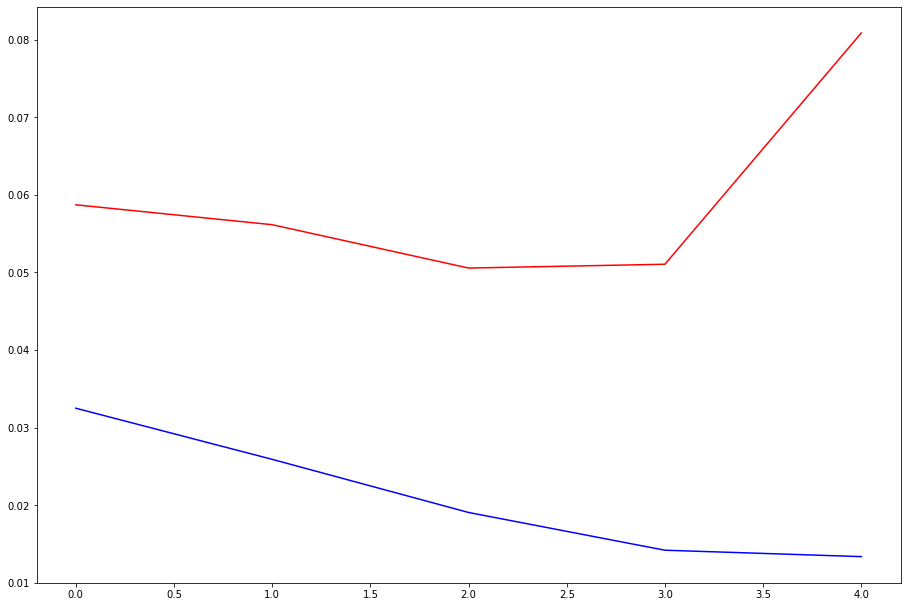

In [14]:
fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['train'])), log['train'], 'b')
axes.plot(range(len(log['val'])), log['val'], 'r')
plt.show()

In [17]:
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.require = False
    
model.fc = nn.Linear(model.fc.in_features, 2)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [20]:
epochs = 3


model.to(device)

def f():
    train_dataloader = DataLoader(train_data.getData(), batch_size=200, shuffle=True)
    for epoch in range(epochs):

        running_loss = 0.0

        for i, data in tqdm(enumerate(train_dataloader)):
            inputs, labels = data[0].to(device), data[-1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(train_dataloader)))

f()

156it [01:01,  2.53it/s]
0it [00:00, ?it/s]

Epoch 0 - Training loss: 0.036954216668024086 


156it [01:03,  2.46it/s]
0it [00:00, ?it/s]

Epoch 1 - Training loss: 0.020825212933302212 


156it [01:02,  2.50it/s]

Epoch 2 - Training loss: 0.010522245133194165 


In [22]:
with torch.no_grad():
    model.eval()

    test_dataloader = DataLoader(test_data.getData(), batch_size=len(test_data), shuffle=True)
    
    for data in test_dataloader:
        inputs, filename = data[0].to(device), data[1]
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

In [23]:
df = pd.DataFrame({
    'sign': predicted.cpu(),
    'filename': filename
})

In [24]:
df

sign                              filename
0       0  4fdbf038-3da9-4710-9587-8d899349c197
1       1  d976e8e8-873a-428f-a7b6-6c7c8e7f985a
2       0  7a31f52d-a615-49f9-aa0a-9fea49439da0
3       0  f9345371-51e3-40f3-b16d-2bf6f42bb9cb
4       0  b7bef275-b2a4-44d3-90f8-fe21b0df4060
..    ...                                   ...
995     1  5d4223f3-dd82-4157-96bd-b819a904cee7
996     0  6002f748-ecdb-4629-9a6d-cc534783cf18
997     0  327a1b9c-e3e4-4bf8-96d3-61c465b9a71c
998     0  ed27c0dc-a3ed-4ebc-9aee-a860b09621b0
999     0  7ba4478b-1bf7-41fa-9fad-9bb3bce0e202

[1000 rows x 2 columns]

In [25]:
df.to_csv('../predict/3.csv', index=False)